In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("Data/house_prices.csv")
df.head()

,house_id,neighborhood,area,bedrooms,bathrooms,style,price
0,1112,B,1188,3,2,ranch,598291
1,491,B,3512,5,3,victorian,1744259
2,5952,B,1134,3,2,ranch,571669
3,3525,A,1940,4,2,ranch,493675
4,5108,B,2208,6,4,victorian,1101539


# Bivariate analysis

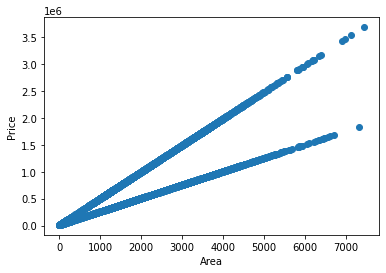

In [3]:
plt.scatter(x=df["area"],y=df["price"])
plt.ylabel("Price")
plt.xlabel("Area")
plt.show()

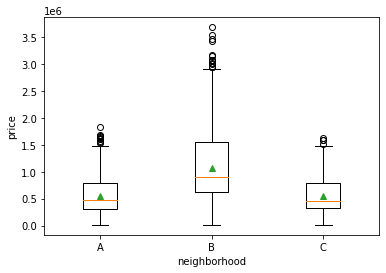

In [4]:
neighborhood_price = df.groupby(['neighborhood'])['price'].apply(np.array)
plt.boxplot(x=neighborhood_price,showmeans=True)
plt.xticks(range(1,4),labels=neighborhood_price.index.values)
plt.ylabel('price')
plt.xlabel('neighborhood')
plt.show()

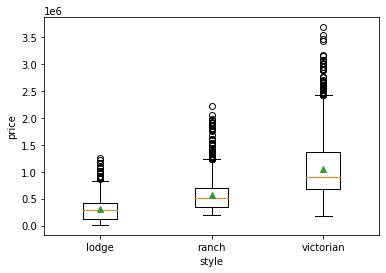

In [5]:
style_price = df.groupby(['style'])['price'].apply(np.array)
plt.boxplot(x=style_price,showmeans=True)
plt.xticks(range(1,4),labels=style_price.index.values)
plt.ylabel('price')
plt.xlabel('style')
plt.show()

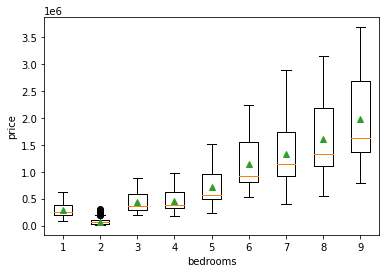

In [6]:
bedrooms_price = df.groupby(['bedrooms'])['price'].apply(np.array)
plt.boxplot(x=bedrooms_price,showmeans=True)
plt.ylabel('price')
plt.xlabel('bedrooms')
plt.show()

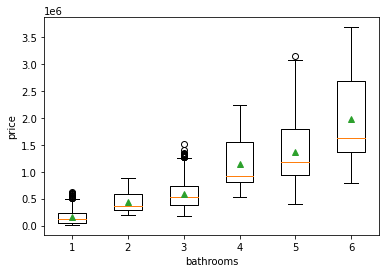

In [7]:
bathrooms_price = df.groupby(['bathrooms'])['price'].apply(np.array)
plt.boxplot(x=bathrooms_price,showmeans=True)
plt.ylabel('price')
plt.xlabel('bathrooms')
plt.show()

In [8]:
neighborhood_bedrooms = df.groupby(['neighborhood'])['bedrooms'].value_counts().unstack()
neighborhood_bedrooms*100/neighborhood_bedrooms.sum(axis=0).values

bedrooms,0,1,2,3,4,5,6,7,8
neighborhood,,,,,,,,,
A,35.510,32.791,30.961,29.325,31.456,31.504,30.447,32.168,30.508
B,42.857,38.211,40.214,40.571,40.307,37.965,42.877,42.657,42.373
C,21.633,28.997,28.826,30.104,28.237,30.531,26.676,25.175,27.119


## Multivariate analysis

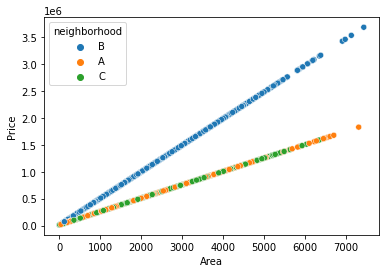

In [9]:
sns.scatterplot(x=df["area"],y=df["price"],hue=df['neighborhood'])
plt.ylabel("Price")
plt.xlabel("Area")
plt.show()

This suggests a possible interaction effect, based on area. The plot tells us that the price increase more effectively for B than for Not B. But is the increase significant? To answer that question, we need to conduct a statistical test.

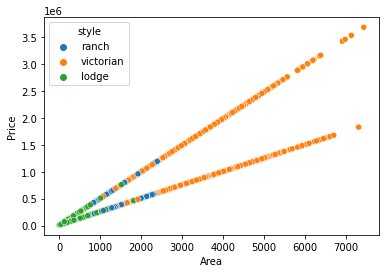

In [10]:
sns.scatterplot(x=df["area"],y=df["price"],hue=df['style'])
plt.ylabel("Price")
plt.xlabel("Area")
plt.show()

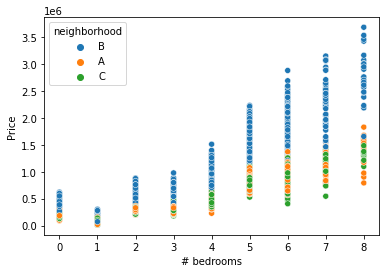

In [11]:
sns.scatterplot(x=df["bedrooms"],y=df["price"],hue=df['neighborhood'])
plt.ylabel("Price")
plt.xlabel("# bedrooms")
plt.show()

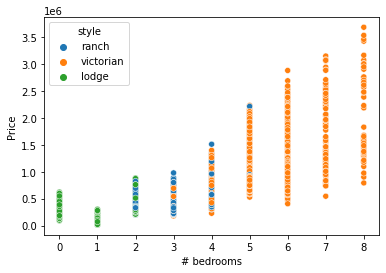

In [12]:
sns.scatterplot(x=df["bedrooms"],y=df["price"],hue=df['style'])
plt.ylabel("Price")
plt.xlabel("# bedrooms")
plt.show()

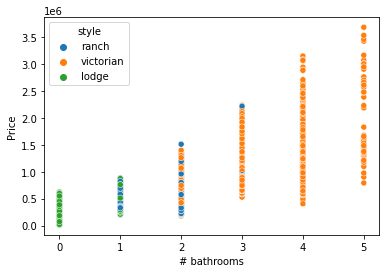

In [13]:
sns.scatterplot(x=df["bathrooms"],y=df["price"],hue=df['style'])
plt.ylabel("Price")
plt.xlabel("# bathrooms")
plt.show()

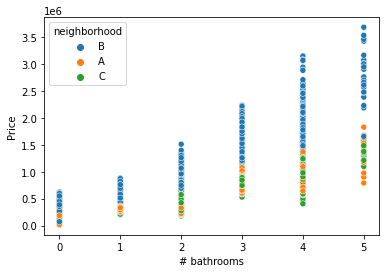

In [14]:
sns.scatterplot(x=df["bathrooms"],y=df["price"],hue=df['neighborhood'])
plt.ylabel("Price")
plt.xlabel("# bathrooms")
plt.show()

In [15]:
new_df = df.join(pd.get_dummies(df['style'])).join(pd.get_dummies(df['neighborhood']))
new_df['intercept'] = 1
new_df['area_B'] = new_df['area']*new_df['B']
new_df.head()

,house_id,neighborhood,area,bedrooms,bathrooms,style,price,lodge,ranch,victorian,A,B,C,intercept,area_B
0,1112,B,1188,3,2,ranch,598291,0,1,0,0,1,0,1,1188
1,491,B,3512,5,3,victorian,1744259,0,0,1,0,1,0,1,3512
2,5952,B,1134,3,2,ranch,571669,0,1,0,0,1,0,1,1134
3,3525,A,1940,4,2,ranch,493675,0,1,0,1,0,0,1,0
4,5108,B,2208,6,4,victorian,1101539,0,0,1,0,1,0,1,2208


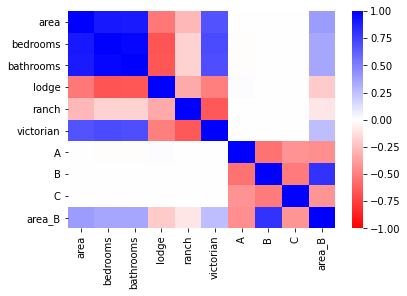

In [16]:
map = new_df[['area', 'bedrooms', 'bathrooms', 'lodge', 'ranch', 'victorian', 'A', 'B', 'C', 'area_B']].corr()
sns.heatmap(map,vmin=-1,vmax=1,cmap='bwr_r')
plt.show()

So 'area, 'bedrooms' and 'bathrooms'. You can see that each of these relationships has pretty strong positive relationships between one another.

identify our predictors is correlated with one another using variance inflation factors VIFs.

In [17]:
y, X = dmatrices('price ~ area + bedrooms + bathrooms + lodge + ranch + A + B + area_B', new_df, return_type = 'dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns 
vif

,VIF Factor,features
0,30.684,Intercept
1,6.621,area
2,22.320,bedrooms
3,19.195,bathrooms
4,2.998,lodge
5,1.716,ranch
6,1.438,A
7,4.427,B
8,4.685,area_B


It appears that the predictor variables are correlated with one another. The variables that appear to be most correlated are the number of bedrooms and bathrooms. So we likely would want to remove at least one of these two variables (bedrooms,bathrooms) as both of their variants inflation factors are larger than 10.

In [22]:
lm = sm.OLS(new_df['price'], new_df[['intercept', 'A', 'B','bedrooms','lodge','ranch','area','area_B']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.156e+11
Date:                Thu, 09 Dec 2021   Prob (F-statistic):               0.00
Time:                        23:15:20   Log-Likelihood:                -26027.
No. Observations:                6028   AIC:                         5.207e+04
Df Residuals:                    6020   BIC:                         5.212e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.207e+04      1.282   9416.839      0.000    1.21e+04    1.21e+04
A             -0.3522      0.606     -0.581      0.561      -1.540       0.836
B            136.7301      1.004    136.237      0.000     134.763     138.698
bedrooms     124.5658      0.384    324.748      0.000     123.814     125.318
lodge         -6.6079      1.002     -6.595      0.000      -8.572      -4.644
ranch         -0.5735      0.669     -0.857      0.392      -1.886       0.739
area         248.0058      0.000   5.16e+05      0.000     248.005     248.007
area_B       244.9998      0.000   6.36e+05      0.000     244.999     245.001
==============================================================================
Omnibus:                    50066.084   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              513.878
Skew:                           0.069   Prob(JB):                    2.59e-112
Kurtosis:                       1.576   Cond. No.                     1.92e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
results.rsquared

0.9999999987982916

99.9% of the variability in price, is explained by the fited variables.

In [19]:
ff = pd.concat([results.params,results.pvalues], axis=1)
ff.columns = ['coef','p_value']
ff

,coef,p_value
intercept,12068.062,0.000
A,-0.352,0.561
B,136.730,0.000
bedrooms,124.566,0.000
lodge,-6.608,0.000
ranch,-0.574,0.392
area,248.006,0.000
area_B,245.000,0.000


* 12068.062 is The predicted home price if the home is a victorian in neighborhood C with an area of 0 and 0 bedrooms.
* 136.730 is The predicted difference in the price of a home in neighborhood in B as compared to neighborhood C, holding other variables constant.
* The predicted difference between the price of a victorian home and a lodge, holding all other variables constant is 6.608.
* For every one unit increase in the area of a home, we predict the price of the home to increase by 248.006, holding all other variables constant
* No statistically significant linear dependence of 'price' on 'ranch' was detected
* No statistically significant linear dependence of 'price' on 'A' was detected